# Prep

In [1]:
%%capture
import sys; sys.path.append('../../..')

# Requires alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats ta-lib (also requires talib C install)
from alpaca_trade_api.rest import REST, TimeFrame
import backtrader as bt
import matplotlib as mpl
import pytz
import datetime
from functools import lru_cache

import datetime

mpl.rcParams['figure.dpi'] = 250

%load_ext dotenv
import os
API_KEY = os.environ['APCA_API_KEY_ID']
SECRET_KEY = os.environ['APCA_API_SECRET_KEY']
assert API_KEY
assert SECRET_KEY
rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')

@lru_cache()
def get_pandas_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")

  if timeframe != TimeFrame.Day:
    alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)

  return alpaca_data

def run_backtest(strategy, symbol: str, start: datetime.date, end: datetime.date, params, cash: float, interval: TimeFrame):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

  data_d = get_pandas_data(symbol, interval, start, end)
  feed1 = bt.feeds.PandasData(dataname=data_d, name=f"{symbol}-{interval}", tz=pytz.timezone('US/Eastern'))
  cerebro.adddata(feed1)

  results = cerebro.run()

  cerebro.plot(iplot=False) # if keep on True, re-running breaks quantstats charts from showing

  strat = results[0]
  return strat

# Strategy

In [2]:
symbol = 'SPY'
start = datetime.date(2015, 1, 1)
end = datetime.date(2022, 7, 18)
cash = 750
interval = TimeFrame.Day
strategy_name = f"{symbol}-sandbox"

In [5]:
class MyStrategy(bt.Strategy):
    params = dict(
      verbose=False,

      cci_period = 20,
      cci_factor = 0.015,  # default, unconfirmed
      cci_upper = 100,
      cci_lower = -90,

      rsi_period = 14,
      rsi_upper = 75,
      rsi_lower = 30,

      longema_period = 50,
    )

    def log(self, *message):
      if self.p.verbose:
        print(self.data.datetime.datetime(0), *message)


    def __init__(self):
      self.rsi = bt.ind.RSI(period=self.p.rsi_period, upperband=self.p.rsi_upper, lowerband=self.p.rsi_lower)
      self.cci = bt.ind.CCI(period=self.p.cci_period, factor=self.p.cci_factor, upperband=self.p.cci_upper, lowerband=self.p.cci_lower)
      self.longema = bt.ind.EMA(period=self.p.longema_period)

      self.buy_signal = bt.And(bt.ind.CrossUp(self.cci.cci, self.p.cci_lower), self.data.close > self.longema)
      self.sell_signal = bt.ind.CrossUp(self.rsi.rsi, self.p.rsi_upper)
      # self.sell_signal = bt.Or(self.rsi.rsi > self.p.rsi_upper, self.data.close < self.longema)

    def next(self):
      # Buy once each time
      if self.buy_signal:
        self.buy(size=1)
      if self.sell_signal:
        self.sell(size=1)

      # Max 1 position at a time
      # if self.position and self.sell_signal:
      #   self.order_target_size(target=0)
      # if not self.position and self.buy_signal:
      #   self.order_target_size(target=1)


In [6]:
strategy = run_backtest(MyStrategy, symbol, start, end,
  {'verbose': True}
  , cash, interval
)

{'verbose': True, 'cci_period': 20, 'cci_factor': 0.015, 'cci_upper': 100, 'cci_lower': -90, 'rsi_period': 14, 'rsi_upper': 75, 'rsi_lower': 30, 'longema_period': 50}


                           Strategy
-------------------------  ----------
Start Period               2015-12-01
End Period                 2022-07-18
Risk-Free Rate             0.0%
Time in Market             91.0%

Cumulative Return          -104.58%
CAGR﹪                     -37.18%

Sharpe                     0.35
Smart Sharpe               0.31
Sortino                    2.3
Smart Sortino              2.06
Sortino/√2                 1.63
Smart Sortino/√2           1.46
Omega                      2.06

Max Drawdown               -141.23%
Longest DD Days            846
Volatility (ann.)          2245.57%
Calmar                     -0.26
Skew                       38.5
Kurtosis                   1544.25

Expected Daily %           nan%
Expected Monthly %         nan%
Expected Yearly %          nan%
Kelly Criterion            24.57%
Risk of Ruin               0.0%
Daily Value-at-Risk        -229.55%
Expected Shortfall (cVaR)  -229.55%

Gain/Pain Ratio            1.06
Gain/Pain (1M)    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-24,2022-01-03,2022-07-18,846,-141.227362,-140.091840
2,2018-12-26,2020-02-19,2020-03-09,439,-39.840677,-38.958987
3,2018-02-09,2018-09-20,2018-12-20,314,-20.049499,-19.759011
4,2017-10-06,2018-01-26,2018-02-05,122,-12.230885,-11.167120
5,2020-03-13,2020-03-13,2020-03-16,3,-11.488726,0.000000


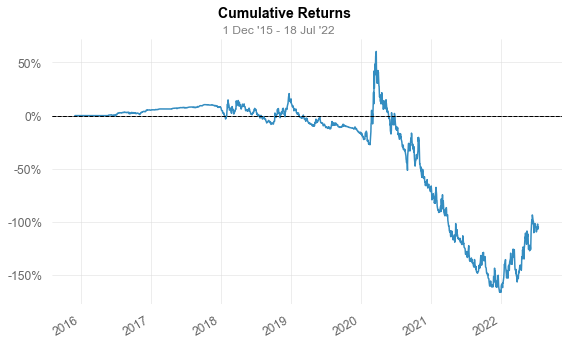

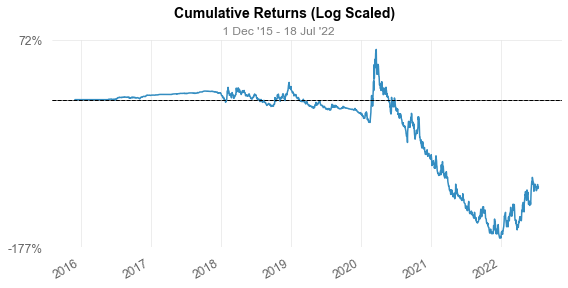

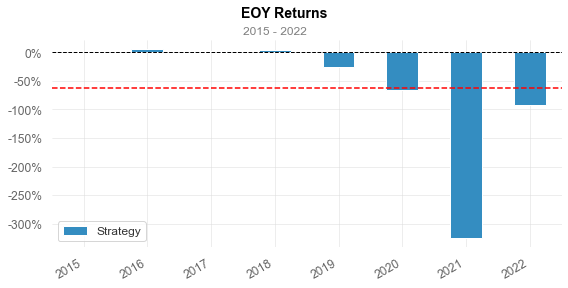

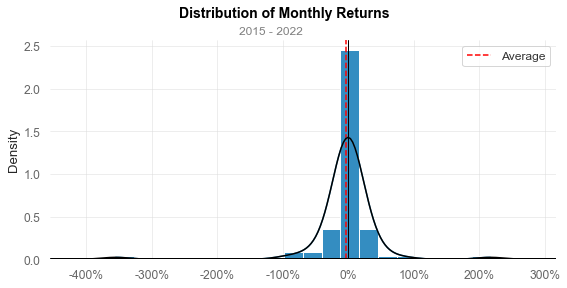

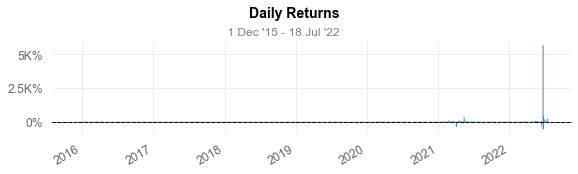

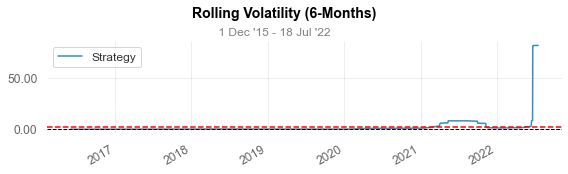

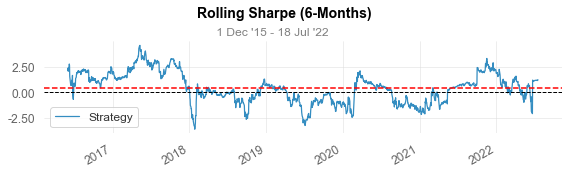

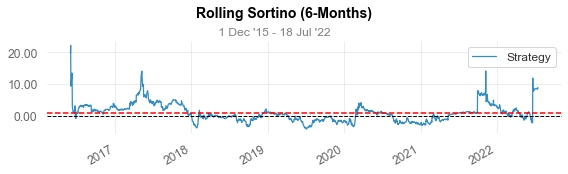

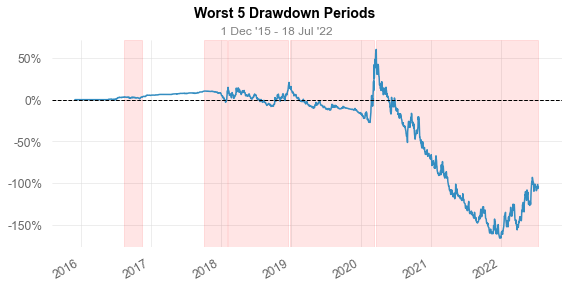

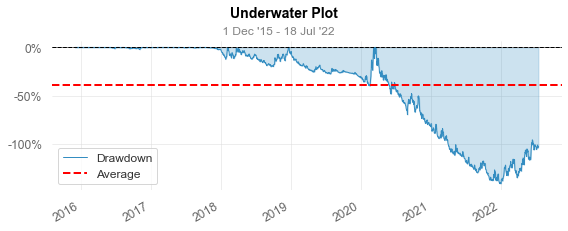

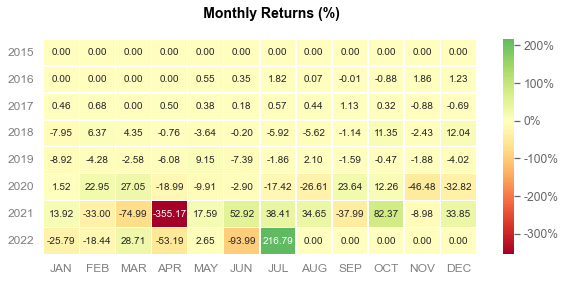

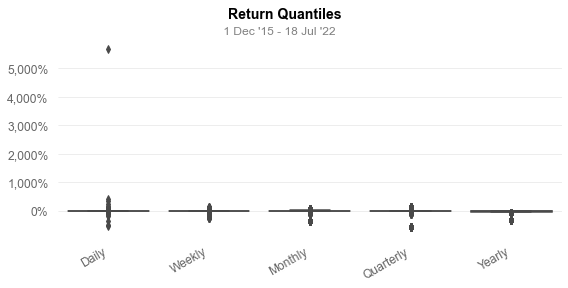

In [7]:
print(strategy.p.__dict__)
import quantstats
portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
quantstats.reports.full(returns)

In [25]:
from src.results import metadata, from_backtest
from src import types

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

from_backtest.write_results(strategy_name, [types.FilledOrder(intention=None,
    symbol=t['symbol'].split('-')[0],  # because datasource is '{symbol}-{interval}', gotta remove the '-{interval}'
    quantity=t['amount'], price=t['price'], datetime=t['time'].to_pydatetime()) for t in transactions.to_dict('records')],
    metadata.from_context("", start, end, strategy.p.__dict__))

# Optimize

In [ ]:
gridsearch = dict(
    # cci_period = [20],
    # cci_factor = [0.015],
    # cci_upper = [-1000],
    # cci_lower = [-100],
)
# update by hand
time_per = datetime.timedelta(seconds=14)


def get_roi(strategy):
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  r = 1
  for ret in annual_returns.values():
    r *= 1 + ret
  r -= 1
  return r

def get_max_drawdown(strategy):
  return strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100


choices = 1
for l in gridsearch.values():
  choices *= len(l)

estimated_time = time_per * choices
print(f"Estimated time (@ {time_per}, {choices}): {estimated_time}")
start_time = datetime.datetime.now()
print(f"(ending at {start_time + (time_per * choices)})")
print("=" * 80)

cerebro = bt.Cerebro(stdstats=True, maxcpus=1)  # inside of VS Code editor, this does not go well
cerebro.broker.setcash(cash)
cerebro.optstrategy(MyStrategy, **gridsearch)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")

data1m = get_pandas_data(symbol, interval, start, end)
feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-{interval}", tz=pytz.timezone('US/Eastern'))
cerebro.adddata(feed1)

runs = cerebro.run()
backtest_results = [results[0] for results in runs]

end_time = datetime.datetime.now()
print(f"Done. Took {end_time - start_time}")
print(f"time per: {(end_time - start_time) / choices}")

In [ ]:
import pandas as pd

def build_row(strategy):
  analysis = strategy.analyzers.tradeanalyzer.get_analysis()
  row = {
    'roi': get_roi(strategy),
    'drawdown': get_max_drawdown(strategy),
    'trades': analysis['total']['total'],
    'average_$': analysis['pnl']['gross']['average'],
    'win_rate': analysis['won']['total'] / analysis['total']['total'],
    'average_win_$': analysis['won']['pnl']['average'],
    'average_loss_$': analysis['lost']['pnl']['average'],
    'params': strategy.p.__dict__
  }
  row.update(strategy.p.__dict__)
  return row
results = pd.DataFrame([build_row(strategy) for strategy in sorted(backtest_results, key=get_roi, reverse=True) if strategy.analyzers.tradeanalyzer.get_analysis()['total']['total'] > 0])

In [ ]:
results.sort_values('roi').tail()

In [ ]:
mpl.rcParams['figure.dpi'] = 150
results.plot(x='roi', y='drawdown', kind='scatter', xlim=(0, .2), ylim=(0, .05), title="Parameter Optimization")